# MeshGraphNets: Learning Mesh-based Simulation with Graph Networks

## I. Introduction
Finite element simulations are a standard for modeling mesh systems, but they are expensive and often domain specific.
Graph neural networks can learn the underlying dynamics in a domain agnostic way and with much cheaper inference.

## II. Background

### II.A. Traditional Simulation Methods
Conventional partial differential equation solvers iteratively compute the system’s state but scale quickly in computational cost with mesh size and resolution.
They are however fairly accurate, interpretable and stable even on long rollouts, as they directly encode the physical laws underlying the modeled interactions.

### II.B. Graph Neural Networks
Graph-structured data presents challenges to common machine learning approaches. Naively processing an adjacency matrix with MLPs discards much of the structure, does not generalize to graphs of different sizes and quickly becomes computationally intractable.
Instead the paradigm of message-passing has emerged, wherein each node is embedded individually and then updated by aggregation of embeddings from adjacent nodes.
The concrete embedding and aggregation scheme is a degree of freedom and several architectures have been proposed, including siblings of non-geometric ML ideas, such as:
- Graph Convolution: sum of neighbors, weighted by the root of the degree of both nodes.
- Graph Attention: learnable weighted sum of adjacent embeddings.
Since each GNN block processes a single hop, the receptive field at each node is simply the number of layers.
Typically this is limited, forcing the network to learn local dynamics, which helps in generalization and prevents oversmoothing of predictions.
For additional details see:

https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html#the-messagepassing-base-class

### II.C. Adaptive Remeshing
Depending on local complexity, different regions of the mesh require different resolutions to balance accuracy and computational cost.
Adaptive meshing refines or coarsens regions based on different criteria expressed through a sizing field. Traditionally this requires domain knowledge, but the sizing field can also be learned to loosen this restriction. (Implementation not published)


## Domains and Datasets
The authors evaluate on cloth simulation, structural deformation, and both compressible and incompressible fluid dynamics. The training data is generated from different simulators.
The method is capable of handling different domains with minimal, if any, adaptation. Many of the problems application even use the same hyperparameters.

| Dataset        | System      | Solver | Mesh Type   | Meshing      | # Steps | ∆t/s |
|----------------|-------------|--------|-------------|--------------|---------|-------|
| FLAGSIMPLE     | cloth       | ArcSim | triangle    | 3D regular   | 400     | 0.02  |
| FLAGDYNAMIC    | cloth       | ArcSim | triangle    | 3D dynamic   | 250     | 0.02  |
| SPHEREDYNAMIC  | cloth       | ArcSim | triangle    | 3D dynamic   | 500     | 0.01  |
| DEFORMINGPLATE | hyper-el.   | COMSOL | tetrahedral | 3D irregular | 400     | —     |
| CYLINDERFLOW   | incompr. NS | COMSOL | triangle    | 2D irregular | 600     | 0.01  |
| AIRFOIL        | compr. NS   | SU2    | triangle    | 2D irregular | 600     | 0.008 |

This notebook uses the example of cylinderflow.
The specific dataset is a timeseries $[g_0, ... g_n]$
Where each $g_i$ consists of:
- x (node features): 2D velocity + one hot encodeded node type. Shape: [n_nodes, 11]
- edge index: adjacency. Shape: [2, n_edges]
- edge attributes. 2D position + 2-norm. Shape: [n_edges, 3]
- y (node outputs). Difference in fluid acceleration to next step. Shape: [n_nodes, 2]
- p (pressure): Unused. Shape: [n_nodes]


In [1]:
import owncloud

oc = owncloud.Client.from_public_link("https://nc.mlcloud.uni-tuebingen.de/index.php/s/feCCBPoSbCiHCWN")
oc.get_file("meshgraphnets_miniset5traj_vis.pt", "data/meshgraphnets.pt")

/home/bileam/.cache/pypoetry/virtualenvs/seminar-meshgraphnets-1a9JqSEb-py3.12/lib/python3.12/site-packages/owncloud/owncloud.py:598: SyntaxWarning: invalid escape sequence '\*'
  """Upload a directory with all its contents
/home/bileam/.cache/pypoetry/virtualenvs/seminar-meshgraphnets-1a9JqSEb-py3.12/lib/python3.12/site-packages/owncloud/owncloud.py:630: SyntaxWarning: invalid escape sequence '\*'
  """Uploads a file using chunks. If the file is smaller than
/home/bileam/.cache/pypoetry/virtualenvs/seminar-meshgraphnets-1a9JqSEb-py3.12/lib/python3.12/site-packages/owncloud/owncloud.py:1741: SyntaxWarning: invalid escape sequence '\*'
  """Makes a OCS API request and analyses the response
/home/bileam/.cache/pypoetry/virtualenvs/seminar-meshgraphnets-1a9JqSEb-py3.12/lib/python3.12/site-packages/owncloud/owncloud.py:1761: SyntaxWarning: invalid escape sequence '\*'
  """Makes a OCS API request
/home/bileam/.cache/pypoetry/virtualenvs/seminar-meshgraphnets-1a9JqSEb-py3.12/lib/python3.12/

HTTPResponseError: HTTP error: 405

In [2]:
import torch
import enum

class NodeType(enum.IntEnum):
    NORMAL = 0
    OBSTACLE = 1
    AIRFOIL = 2
    HANDLE = 3
    INFLOW = 4
    OUTFLOW = 5
    WALL_BOUNDARY = 6
    SIZE = 9


DATAPATH = "data/"
def load_dataset():
    return torch.load(DATAPATH + "meshgraphnets.pt", weights_only=False)

def load_testset():
    return torch.load(DATAPATH + "test_processed_set.pt", weights_only=False)

In [4]:
dataset = load_dataset()
print("dataset size:", len(dataset))
print("x shape:", dataset[0].x.shape)
print("edge_index shape:", dataset[0].edge_index.shape)
print("edge_attr shape:", dataset[0].edge_attr.shape)
print("y shape:", dataset[0].y.shape)

dataset size: 2995
x shape: torch.Size([1923, 11])
edge_index shape: torch.Size([2, 11070])
edge_attr shape: torch.Size([11070, 3])
y shape: torch.Size([1923, 2])


### III.A. Preprocessing
The mesh is augmented with world edges, nodes that are close in world space are connected to model collisions.
Originally two separate edge MLPs are learned for this purpose, however indicating whether an edge belongs to the mesh- or world graph as part of the edge features is equally as expressive and this step therefore ignored in our reimplementation.
In addition the graph is remeshed as described in II.C
The authors (deepmind) work with the tensorflow TFrecord data format, we use Rayan Kanfar's (https://github.com/kanfarrs/) translation code to obtain torch compatible data.
Dataset statistics (mean + std dev) are collected from train data and applied to normalize at inference.
The model operates on relative coordinates for robustness.
Additionally, all features are normalized to zero mean and unit variance.

In [5]:
def get_stats(data_list):
    '''
    Taken from:
    https://colab.research.google.com/drive/1mZAWP6k9R0DE5NxPzF8yL2HpIUG3aoDC?usp=sharing

    Method for normalizing processed datasets. Given  the processed data_list,
    calculates the mean and standard deviation for the node features, edge features,
    and node outputs, and normalizes these using the calculated statistics.
    '''

    #mean and std of the node features are calculated
    mean_vec_x=torch.zeros(data_list[0].x.shape[1:])
    std_vec_x=torch.zeros(data_list[0].x.shape[1:])

    #mean and std of the edge features are calculated
    mean_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])
    std_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])

    #mean and std of the output parameters are calculated
    mean_vec_y=torch.zeros(data_list[0].y.shape[1:])
    std_vec_y=torch.zeros(data_list[0].y.shape[1:])

    #Define the maximum number of accumulations to perform such that we do
    #not encounter memory issues
    max_accumulations = 10**6

    #Define a very small value for normalizing to
    eps=torch.tensor(1e-8)

    #Define counters used in normalization
    num_accs_x = 0
    num_accs_edge=0
    num_accs_y=0

    #Iterate through the data in the list to accumulate statistics
    for dp in data_list:

        #Add to the
        mean_vec_x+=torch.sum(dp.x,dim=0)
        std_vec_x+=torch.sum(dp.x**2,dim=0)
        num_accs_x+=dp.x.shape[0]

        mean_vec_edge+=torch.sum(dp.edge_attr,dim=0)
        std_vec_edge+=torch.sum(dp.edge_attr**2,dim=0)
        num_accs_edge+=dp.edge_attr.shape[0]

        mean_vec_y+=torch.sum(dp.y,dim=0)
        std_vec_y+=torch.sum(dp.y**2,dim=0)
        num_accs_y+=dp.y.shape[0]

        if(num_accs_x>max_accumulations or num_accs_edge>max_accumulations or num_accs_y>max_accumulations):
            break

    mean_vec_x = mean_vec_x/num_accs_x
    std_vec_x = torch.maximum(torch.sqrt(std_vec_x/num_accs_x - mean_vec_x**2),eps)

    mean_vec_edge = mean_vec_edge/num_accs_edge
    std_vec_edge = torch.maximum(torch.sqrt(std_vec_edge/num_accs_edge - mean_vec_edge**2),eps)

    mean_vec_y = mean_vec_y/num_accs_y
    std_vec_y = torch.maximum(torch.sqrt(std_vec_y/num_accs_y - mean_vec_y**2),eps)

    mean_std_list=[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y]

    return mean_std_list


## IV. Model Architecture
The chosen architecture is very similar to unnormalized graph convolution, with the addition of edge embeddings.
First nodes and edges are embedded, then in a number of processing steps the embeddings are updated according to adjacency.
At each step the edge embeddings are updated via MLP of concatenated adjacent nodes + residual.
Then the node embeddings are updated via MLP of previous node embedding concatenated with the edge embeddings + residual.
Finally the node embeddings are decoded for the quantity of interest (f.e. velocity).


In [6]:
from torch import nn
from torch_geometric.nn import MessagePassing




class ProcessingLayer(MessagePassing):
    def __init__(self, node_dim, edge_dim):
        super().__init__()
        self.node_mlp = nn.Sequential(
                nn.Linear(2*node_dim, node_dim),
                nn.ReLU(),
                nn.Linear(node_dim, node_dim),
                nn.LayerNorm(node_dim),
            )
        self.edge_mlp = nn.Sequential(
                nn.Linear(2*node_dim+edge_dim, edge_dim),
                nn.ReLU(),
                nn.Linear(edge_dim, edge_dim),
                nn.LayerNorm(edge_dim),
            )

        self.reset_parameters()

    def reset_parameters(self):
        for i in [0,2]:
            self.node_mlp[i].reset_parameters()
            self.edge_mlp[i].reset_parameters()

    def forward(self, x, edge_index, edge_attr, size=None):
        """
        Propagate messages to update embeddings.

        Args:
        x [n_nodes, node_dim]: node embeddings
        edge_index [2, n_edges]
        edge_attr [E, edge_dim]

        """
        # edge update
        out, updated_edges = self.propagate(edge_index=edge_index, x=x, edge_attr=edge_attr, size=size)

        # residual and node update
        updated_nodes = x + self.node_mlp(torch.cat([x, out], dim=1))
        return updated_nodes, updated_edges
    
    def message(self, x_i, x_j, edge_attr):
        """
        This computes the message to be passed from node i to node j.
        x_i [E, node_dim]: source node embedding 
        x_j [E, node_dim]: target node embedding 
        edge_attr [E, edge_dim]
        """
        updated_edges = torch.cat([x_i, x_j, edge_attr], dim=1)
        # edge update with residual
        return self.edge_mlp(updated_edges) + edge_attr

    def aggregate(self, updated_edges, edge_index, dim_size=None):
        """
        This aggregates the messages from all the neighbors by addition.
        """
        # scatter add without dependency
        src = updated_edges
        out_size = list(src.size())
        out_size[0] = edge_index.max().item()+1
        out = torch.zeros(out_size, dtype=src.dtype, device=src.device)
        out.index_add_(dim=0, index=edge_index[0, :], source=src)
        return out, updated_edges


class MeshGraphNet(nn.Module):
    def __init__(
            self,
            input_dim_node,
            input_dim_edge,
            output_dim,
            args,
        ):
        super().__init__()
        self.num_layers = args["num_layers"]
        self.hidden_dim = args["hidden_dim"]
        self.node_encoder = nn.Sequential(
                nn.Linear(input_dim_node, self.hidden_dim),
                nn.ReLU(),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.LayerNorm(self.hidden_dim),
            )

        self.edge_encoder = nn.Sequential(
                nn.Linear(input_dim_edge, self.hidden_dim),
                nn.ReLU(),
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.LayerNorm(self.hidden_dim),
            )

        self.processor_blocks = []
        for _ in range(self.num_layers):
            self.processor_blocks.append(ProcessingLayer(self.hidden_dim, self.hidden_dim))

        self.decoder = nn.Sequential(
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.ReLU(),
                nn.Linear(self.hidden_dim, output_dim)
                )

    def forward(self, data, mean_x, std_x, mean_edge, std_edge):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # normalize nodes and edges
        x = (x-mean_x)/std_x
        edge_attr = (edge_attr-mean_edge)/std_edge


        # encode nodes and edges
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)

        # update embeddings using processor layers
        for layer in self.processor_blocks:
            x, edge_attr = layer(x, edge_index, edge_attr)

        # decode node embeddings
        return self.decoder(x)

    def loss(self, pred, inputs, mean_y, std_y):
        # normalize labels
        labels = (inputs.y-mean_y)/std_y

        # create mask for nodes of interest
        loss_mask = torch.logical_or((torch.argmax(inputs.x[:,2:],dim=1)==NodeType.NORMAL),
                                    (torch.argmax(inputs.x[:,2:],dim=1)==NodeType.OUTFLOW))

        # calculate total error 
        loss = torch.sum((labels-pred)**2, axis=1)
        # mask and mean
        return torch.mean(loss[loss_mask])


In [7]:
TRAIN_SIZE = 10
TEST_SIZE = 2
DEVICE = "cpu"

ARGS = {
    "num_layers": 2,
    "batch_size": 16,
    "hidden_dim": 10,
    "epochs": 128,
    "lr": 5e-3,
    "weight_decay": 5e-4,
}

In [8]:
from torch_geometric.loader import DataLoader

dataloader = DataLoader(dataset[:TRAIN_SIZE])
# testloader = DataLoader(dataset[TRAIN_SIZE:TRAIN_SIZE+TEST_SIZE])

[mean_x,std_x,mean_edge,std_edge,mean_y,std_y] = list(map(lambda x: x.to(DEVICE), get_stats(dataset)))

model = MeshGraphNet(
        input_dim_node=dataset[0].x.shape[1],
        input_dim_edge=dataset[0].edge_attr.shape[1],
        output_dim=2, # velocity
        args=ARGS,
        )
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
opt = torch.optim.Adam(trainable_params, lr=ARGS["lr"], weight_decay=ARGS["weight_decay"])

In [9]:
# Untrained
untrained = []
with torch.no_grad():
    for data in dataloader:
        pred = model(data, mean_x, std_x, mean_edge, std_edge)
        untrained.append(pred)

In [10]:
epoch_losses = []

for epoch in range(ARGS["epochs"]):
    model.train()
    batch_losses = []
    for batch in dataloader:
        batch = batch.to(DEVICE)
        opt.zero_grad()
        pred = model(batch, mean_x, std_x, mean_edge, std_edge)
        loss = model.loss(pred, batch, mean_y, std_y)
        loss.backward()
        opt.step()
        batch_losses.append(loss.item())
    
    # Calculate the average loss for the epoch
    avg_loss = sum(batch_losses) / len(batch_losses)
    print(avg_loss)
    epoch_losses.append(avg_loss)


17.051046633720397
16.58592586517334
16.453882813453674
16.166307950019835
15.67494444847107
15.163878965377808
14.542038631439208
14.185936856269837
13.937956976890565
13.71014654636383
13.529186725616455
13.192194366455078
13.102590298652649
12.871562051773072
12.635829377174378
12.381403994560241
12.338350582122803
12.094416117668152
11.845152115821838
11.634255695343018
11.495865035057069
11.457238817214966
11.297485756874085
11.024129486083984
10.943461179733276
10.716715550422668
11.053651356697083
11.728311419487
11.273056888580323
10.752971076965332
10.594539618492126
10.31381185054779
10.521306777000428
10.15565071105957
10.1741046667099
9.973706603050232
9.999381613731384
9.82193989753723
9.898724246025086
9.84588942527771
9.79787893295288
9.739745283126831
9.592438817024231
9.636786293983459
9.469303965568542
9.616776204109192
9.509649920463563
9.519021153450012
9.49175329208374
9.387999248504638
9.369757890701294
9.220836949348449
9.233945751190186
9.019395184516906
9.40377

In [11]:
# Trained
trained = []
with torch.no_grad():
    for data in dataloader:
        pred = model(data, mean_x, std_x, mean_edge, std_edge)
        trained.append(pred)



## V. Results
MeshGraphNets deliver accurate long rollouts at speeds up to two orders of magnitude faster than the solvers. They outperform particle-based and grid-based baselines, with smaller errors in challenging regimes. They also scale and generalize well at inference, enabling simulations larger than or fundamentally different from anything seen in training.


In [12]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

N_FRAMES = 4
def generate_gif(cumsum, scale=None):
    mesh_pos = dataset[0].mesh_pos
    fig, ax = plt.subplots()
    quiver = ax.quiver(mesh_pos[:, 0], mesh_pos[:, 1], cumsum[0][:, 0], cumsum[0][:, 1],scale=scale)

    def update(i):
        quiver.set_UVC(cumsum[i][:, 0], cumsum[i][:, 1])
        return quiver,

    ani = FuncAnimation(fig, update, frames=len(cumsum), interval=50, blit=True)
    ani.save("quiver.gif", writer="pillow", fps=2)

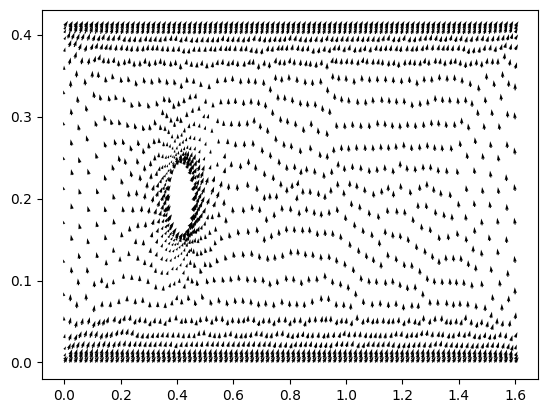

In [13]:
trained_cumsum = torch.stack(trained).cumsum(dim=0)
untrained_cumsum = torch.stack(untrained).cumsum(dim=0)
generate_gif(untrained)

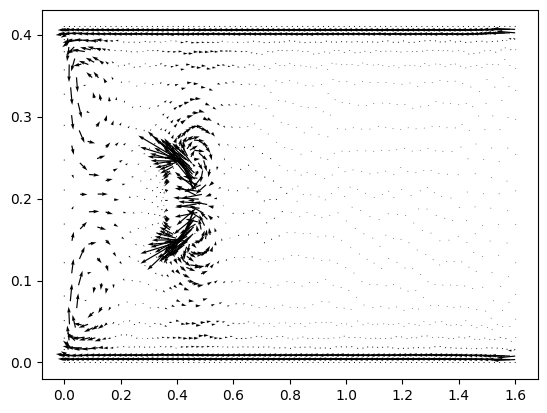

In [14]:
gt_cumsum = torch.stack([x.y for x in dataset[:N_FRAMES]]).cumsum(dim=0)
generate_gif(gt_cumsum, scale=1500)

For much prettier examples across different datasets, see:
https://sites.google.com/view/meshgraphnets


## VI. Tricks

### VI.A Training Noise
To improve rollout stability, noise can be injected during training, nudging the model towards self correcting behavior.
As small predictions inevitably accumulate at inference, the authors report that a model used to noisy environments is much more robust to this.
Empirically predictions stay plausible even after tens of thousands of rollout steps.
